<a href="https://colab.research.google.com/github/sraghav42/machine_learning/blob/master/movie_recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Add, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

In [3]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

--2020-06-11 17:10:29--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  1.49MB/s    in 0.6s    

2020-06-11 17:10:30 (1.49 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]



In [4]:
!unzip ml-latest-small.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [5]:
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [6]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.groupby(['userId']).count()

,movieId,rating,timestamp
userId,,,
1,232,232,232
2,29,29,29
3,39,39,39
4,216,216,216
5,44,44,44
...,...,...,...
606,1115,1115,1115
607,187,187,187
608,831,831,831


In [7]:
ratings = ratings.merge(movies, on='movieId').drop(['genres','timestamp'],axis=1)
ratings.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


In [8]:
user_enc = LabelEncoder()
ratings['userSeq'] = user_enc.fit_transform(ratings['userId'].values)

item_enc = LabelEncoder()
ratings['movieSeq'] = item_enc.fit_transform(ratings['movieId'].values)

ratings.head()

,userId,movieId,rating,title,userSeq,movieSeq
0,1,1,4.0,Toy Story (1995),0,0
1,5,1,4.0,Toy Story (1995),4,0
2,7,1,4.5,Toy Story (1995),6,0
3,15,1,2.5,Toy Story (1995),14,0
4,17,1,4.5,Toy Story (1995),16,0


In [9]:
train_unused, test = train_test_split(ratings, test_size=0.20, random_state=0)

# All data is used for training
train = ratings

numUsers = len(train.userSeq.unique())
numMovies = len(train.movieSeq.unique())
print((numUsers, numMovies))
print((len(train), len(test)))

(610, 9724)
(100836, 20168)


In [10]:
numFeatures = 50
dropout = 0.0

user_input = Input(shape=(1,))
user_emb = Embedding(numUsers, numFeatures)(user_input)
flat_user = Flatten()(user_emb)
user_dropout = Dropout(dropout)(flat_user)

movie_input = Input(shape=(1,))
movie_emb = Embedding(numMovies, numFeatures)(movie_input)
flat_movie = Flatten()(movie_emb)
movie_dropout = Dropout(dropout)(flat_movie)

dotProduct = Dot(axes=1)([user_dropout, movie_dropout])

user_bias = Embedding(numUsers, 1)(user_input)
movie_bias = Embedding(numMovies, 1)(movie_input)
sum = Add()([dotProduct, user_bias, movie_bias])
flat_sum = Flatten()(sum)
output = Dropout(dropout)(flat_sum)

model = Model([user_input, movie_input], output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        30500       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        486200      input_2[0][0]                    
______________________________________________________________________________________________

Epoch 1/10
3152/3152 [==============================] - 27s 8ms/step - loss: 6.2104 - val_loss: 1.4670
Epoch 2/10
3152/3152 [==============================] - 26s 8ms/step - loss: 1.1501 - val_loss: 0.8049
Epoch 3/10
3152/3152 [==============================] - 26s 8ms/step - loss: 0.8072 - val_loss: 0.6360
Epoch 4/10
3152/3152 [==============================] - 26s 8ms/step - loss: 0.6658 - val_loss: 0.5284
Epoch 5/10
3152/3152 [==============================] - 26s 8ms/step - loss: 0.5577 - val_loss: 0.4423
Epoch 6/10
3152/3152 [==============================] - 26s 8ms/step - loss: 0.4671 - val_loss: 0.3655
Epoch 7/10
3152/3152 [==============================] - 26s 8ms/step - loss: 0.3907 - val_loss: 0.3006
Epoch 8/10
3152/3152 [==============================] - 26s 8ms/step - loss: 0.3228 - val_loss: 0.2468
Epoch 9/10
3152/3152 [==============================] - 26s 8ms/step - loss: 0.2667 - val_loss: 0.2005
Epoch 10/10
3152/3152 [==============================] - 26s 8ms/step - l

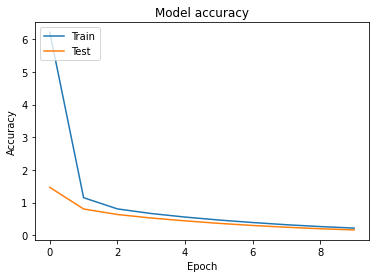

In [11]:
model.compile(loss='mean_squared_error', optimizer=Adam())
history = model.fit([train.userSeq, train.movieSeq], train.rating,
                    batch_size=32, epochs=10, verbose=1,
                    validation_data=([test.userSeq, test.movieSeq], test.rating))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
# The user for whom we want to make recommendations
userNumber = 21

uniqueMovies = ratings.drop_duplicates(subset=['movieSeq'])

movie_vector = uniqueMovies.movieSeq.values
user_vector = np.ones((len(uniqueMovies),)) * userNumber
predictions = model.predict([user_vector, movie_vector])
predictedDF = uniqueMovies.copy()
predictedDF['Predictions'] = predictions

predictedDF.sort_values(by='Predictions', ascending=False).head(5)

,userId,movieId,rating,title,userSeq,movieSeq,Predictions
27902,6,25,3.0,Leaving Las Vegas (1995),5,24,4.823995
854,1,110,4.0,Braveheart (1995),0,97,4.804711
25036,5,34,4.0,Babe (1995),4,32,4.796081
48535,16,541,4.5,Blade Runner (1982),15,474,4.794593
4649,1,608,5.0,Fargo (1996),0,520,4.694968


In [13]:
oneUser = predictedDF[predictedDF.userSeq == userNumber].copy()
oneUser['Error'] = (oneUser.rating - oneUser.Predictions)**2
oneUser.sort_values(by='Error', ascending=False).head(5)

,userId,movieId,rating,title,userSeq,movieSeq,Predictions,Error
69215,22,8464,0.5,Super Size Me (2004),21,5190,1.414167,0.835701
69265,22,8622,0.5,Fahrenheit 9/11 (2004),21,5245,1.328357,0.686174
69141,22,6711,4.0,Lost in Translation (2003),21,4522,3.196040,0.646352
69684,22,56782,4.0,There Will Be Blood (2007),21,6631,3.218738,0.610371
68924,22,1952,5.0,Midnight Cowboy (1969),21,1428,4.367399,0.400184


In [14]:
ratings[ratings.movieSeq == 520].sort_values(by='rating', ascending=True)

,userId,movieId,rating,title,userSeq,movieSeq
4827,607,608,2.0,Fargo (1996),606,520
4672,78,608,2.0,Fargo (1996),77,520
4810,546,608,2.0,Fargo (1996),545,520
4669,71,608,2.0,Fargo (1996),70,520
4812,554,608,2.0,Fargo (1996),553,520
...,...,...,...,...,...,...
4725,251,608,5.0,Fargo (1996),250,520
4718,221,608,5.0,Fargo (1996),220,520
4717,220,608,5.0,Fargo (1996),219,520
4754,324,608,5.0,Fargo (1996),323,520
